# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

Я разбирался в торче пока делал этот семинар, так что относитесь к моим наработкам как к обучающему материалу, а не стандарту. Скорее всего, есть более правильные, эффективные, красивые решения. 

In [1]:
# !pip install torch torch-vision

In [5]:
# !pip install pandas scikit-learn matplotlib

## Сверточные нейронные сети

Несколько полносвязных слоев (с нелинейностями посередине) - это уже полноценная нейронная сеть. Однако cам по себе полносвязный слой обычно встречается только в конце сети, когда нужно получить распределение по классам или итоговое значение (в регрессии). Дальше мы разберем три более сложных типа слоев: сверточные, реккуретные и трасформерные. Все они так или иначе нацелены на учитывание структуры данных. 

В этом семинаре мы попробуем использовать сверточные слои. Лучше всего они работают в картинках (мы тоже это попробуем в конце семинара), но для текстов их тоже можно применять (они быстрее рекуррентных и могут лучше работать на длинных последовательностях). И в целом они подходят для любых последовательных данных. К последовательности тоже можно применять полносвязный слой, но либо к каждому элементу по отдельности либо нужно соединить отдельные элементы в один входной вектор и применить полносвязный слой сразу ко всему. Оба этих варианта работают так себе, так как в первом не учитывается последовательность (опять получается мешок слов), а во втором мешает то, что последовательности бывают разной длины и отдельные части могут менять свои позиции. В сверточных сетях используется промежуточное решение - объеденяются только несколько стоящих к друг друг векторов и используется скользящее окно, чтобы применить полносвязный слой к отдельным группам векторов. Это по сути объединение токенов в нграммы! Таким образом в сверточных сетях учитывается локальная информация о последовательности. Давайте посмотрим на картинках:

Обычный полносвязный слой:  
[![Screenshot-2025-01-23-at-12-21-16.png](https://i.postimg.cc/ryZ2Lt8K/Screenshot-2025-01-23-at-12-21-16.png)](https://postimg.cc/Z0NM8nvS)

Применение полносвязного слоя к каждому элементу по отдельности:  
[![Screenshot-2025-01-23-at-12-21-42.png](https://i.postimg.cc/jSg7HcKR/Screenshot-2025-01-23-at-12-21-42.png)](https://postimg.cc/RWth9cNY)

Конкатенация всех векторов в один и применение полносвязнного слоя:  
[![Screenshot-2025-01-23-at-12-21-51.png](https://i.postimg.cc/D09CwhjY/Screenshot-2025-01-23-at-12-21-51.png)](https://postimg.cc/H8t06qCQ)

Группировка векторов и применение векторов к отдельным группам скользящим окном (сверточная сеть):  
[![Screenshot-2025-01-23-at-12-22-02.png](https://i.postimg.cc/wvs483Fs/Screenshot-2025-01-23-at-12-22-02.png)](https://postimg.cc/ZB4x6bGT)


Можно еще посмотреть на каждую строчку в матрице весов полносвязного слоя по отдельности и тогда получится, что к каждой группе векторов применяется один вектор, а в результате получается одно число. Между двумя векторами считается скалярное произведение и поэтому можно думать про это как расчет близости! По сути в сверточной сети происходит поиск паттернов в данных. Только эти паттерны модель создает сама в процессе обучения и затем ищет похожие во входных данных. 


Идея гораздно нагляднее в примере с картинкой. В этом случае модель как бы пробегает по картинке взглядом, при это на каждом шаге фокус очень небольшой и модель не видит то, что вокруг. Каждый маленький полновсвязный ищет взглядом на картинке/тексте что-то свое и, если он это находит, то он активируется. В итоге получается абстрактное описание того, что изображено на картинке.

![](https://miro.medium.com/v2/resize:fit:1052/0*jLoqqFsO-52KHTn9.gif)

## Классификация с помощью CNN

Давайте посмотрим, как в торче использовать сверточные сети и как их соединять с Embedding и Linear слоями.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [8]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# данные - статьи из ленты ру, нужно предсказать категорию новости
data = pd.read_csv('lenta_40k.csv.zip')

In [10]:
data.dropna(subset=['topic', 'text'], inplace=True)

In [11]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


Предобработка нам тут особо не важна.

In [12]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

В предыдущей домашке не хватало фмеры. Ее нет в керасе, но можно взять вот такую функцию (взятую со стаковерфлоу)

Предобработка точно такая же

In [13]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [14]:
len(vocab)

354611

In [15]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [16]:
len(filtered_vocab)

24091

In [17]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [18]:
id2word = {i:word for word, i in word2id.items()}

Обертка для данных - такая же как и в предыдущем семинаре

In [19]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить 
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [20]:
MAX_LEN = 200

In [21]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [22]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [23]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True, )

In [24]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True)

Для сравнения сначала обучим сеть только с помощью Dense слоев. Трейн луп такой же как и в предыдущем семинаре

In [25]:
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import numpy as np

def train(model, iterator, optimizer, criterion):
    model.train()

    epoch_loss = []
    epoch_f1 = []

    pbar = tqdm(iterator, desc="Training", leave=False)

    for texts, ys in pbar:
        optimizer.zero_grad()

        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))

        loss.backward()
        optimizer.step()

        preds = predictions.detach().cpu().numpy().argmax(1)
        y_true = ys.numpy()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        # Update tqdm bar
        pbar.set_postfix(
            loss=np.mean(epoch_loss),
            f1=np.mean(epoch_f1)
        )

    return np.mean(epoch_f1)



def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = []
    epoch_f1 = []

    with torch.no_grad():
        for texts, ys in tqdm(iterator, desc="Evaluating", leave=False):
            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))

            preds = predictions.detach().cpu().numpy().argmax(1)
            y_true = ys.numpy()

            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)


In [26]:
# сеть с двумя полносвязными слоями и активацией
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden, output_dim):
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, hidden)
        self.fc_1 = nn.Linear(hidden, output_dim)
        self.act = nn.LogSoftmax(1) 
        self.relu = nn.ReLU()       
        
    def forward(self, text):
        embedded = self.embedding(text)   
        hidden = torch.mean(embedded, dim=1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 

        outputs=self.act(dense_outputs)
        
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 30, len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

Запускаем обучение

In [27]:
f1s = []
f1s_eval = []

for epoch in range(10):
    print(f"\nEpoch {epoch+1}/10")

    train_f1 = train(model, training_generator, optimizer, criterion)
    val_f1 = evaluate(model, valid_generator, criterion)

    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    f1s.append(train_f1)
    f1s_eval.append(val_f1)



Epoch 1/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.2160 | Val F1: 0.2145

Epoch 2/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.2409 | Val F1: 0.2821

Epoch 3/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.3710 | Val F1: 0.4542

Epoch 4/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.5206 | Val F1: 0.5545

Epoch 5/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.5904 | Val F1: 0.5999

Epoch 6/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6308 | Val F1: 0.6266

Epoch 7/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6604 | Val F1: 0.6524

Epoch 8/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6891 | Val F1: 0.6711

Epoch 9/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7146 | Val F1: 0.6906

Epoch 10/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7357 | Val F1: 0.7104


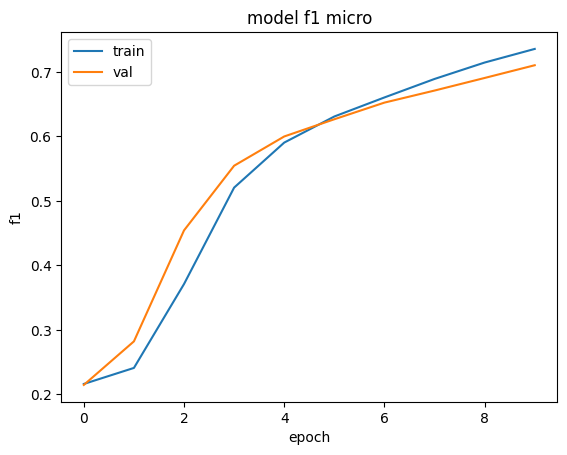

In [28]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Посмотрим еще максимальную f меру

In [29]:
max(f1s_eval)

0.7103707107843138

Теперь попробуем сверточные слои. В торче сверточные слои не очень простые - нужно подробно разобраться в параметрах и расчитывать изменения в размере последовательности вручную. Прежде чем писать всю сеть давайте выделим сверточный слой и посмотрим как он преобразует данные

In [34]:
# сгенерируем тензор похожий на реальные данные
batch_size = 2
in_channels = 3 # при работе с текстами это будет размер эмбединга 
sequence_length = 10 # а это max_len

x = torch.randn(batch_size, in_channels, sequence_length)

print("Input shape:", x.shape)

Input shape: torch.Size([2, 3, 10])


В торче обычно принято использовать (B, C, N) формат, но (B, N, C) часто тоже используется потому что он более интуитивный и можно часть увидеть в коде что-то вроде

In [42]:
# так можно переставить размерности местами
x.permute(0, 2, 1).size()

torch.Size([2, 10, 3])

Применим сверточный слой к нашему тензору

In [36]:
conv1d = nn.Conv1d(
    in_channels=3, 
    out_channels=5,
    kernel_size=3,
    stride=1
)
y = conv1d(x)
print("Output shape:", y.shape)

Output shape: torch.Size([2, 5, 8])


Входные параметры влияют на итоговый размер. Рассчитать его можно по такой формуле (взято отсюда - https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)

Пока опустим padding (2 * padding зануляется и можно его убрать) и не будем трогать dilation (он равен 1 по умолчанию и его можно убрать).

![](https://i.ibb.co/Ps6w7d4b/image.png)

In [40]:
L_in = sequence_length
kernel_size = 3
stride = 1

output_length = ((L_in - (kernel_size - 1) - 1) // stride) + 1
print("Expected output length:", output_length)

Expected output length: 8


In [30]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__() 
        # параметры лучше передавать снаружи
        # но для простоты напишем тут
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100 # размерность эмбединга слов
        self.KERNEL_SIZE = 10 # размер фильтров в CNN, влияет на выходную длину последовательности
        self.MAX_LEN = 200 # длина последовательности до которой западили 
        self.IN_CHANNELS = self.EMB_DIM # параметр который нужно передать в CNN, соответствующий размеру эмбединга
        self.OUT_CHANNELS = 32 # количество фильтров в CNN, будет соответствовать размерности векторов на выходе из CNN
        self.STRIDE = 1 # параметр CNN влияющий на выходную длину последовательности
        self.HIDDEN_FC = 64 # перед финальной классификацией поставим еще один полносвязный слой
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE, ) 
        
        # к выходу из CNN и к выходу промежуточного полносвязного слоя нужно применить активацию
        self.relu = nn.ReLU() 
        
        
        # расчитываем по формуле размерность получившейся последовательности
        # умножаем на OUT_CHANNELS чтобы получить размер вектора
        # который получиться если конкатенировать все в 1 вектор
        
        
        self.flattened_size = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1)*self.OUT_CHANNELS)
        
        # используем размер вектора для определения полносвязного слоя
        self.fc = nn.Linear(self.flattened_size, 
                            self.HIDDEN_FC)
        
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        
        # сверточный слой ожидает на вход последовательность такого вида
        # (batch_size, emb_dim, max_len)
        # а у нас получается 
        # (batch_size, max_len, emb_dim)
        # поэтому используем permute чтобы поменять местами max_len и emb_dim
        embedded = self.embedding(text).permute(0, 2, 1)
        
        convoluted = self.relu(self.conv(embedded)) # пропускаем через свертку и применяем релу
        hidden = torch.flatten(convoluted, 1, -1) # конкатенируем
        hidden = self.relu(self.fc(hidden))  # подаем в полносвязный и применяем активацию
        
        dense_outputs = self.fc_1(hidden) 
        outputs=self.act(dense_outputs) 
        
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [31]:
f1s = []
f1s_eval = []

for epoch in range(10):
    print(f"\nEpoch {epoch+1}/10")

    train_f1 = train(model, training_generator, optimizer, criterion)
    val_f1 = evaluate(model, valid_generator, criterion)

    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    f1s.append(train_f1)
    f1s_eval.append(val_f1)



Epoch 1/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.3457 | Val F1: 0.5378

Epoch 2/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6217 | Val F1: 0.6331

Epoch 3/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7450 | Val F1: 0.6618

Epoch 4/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.8378 | Val F1: 0.6671

Epoch 5/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9140 | Val F1: 0.6630

Epoch 6/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9658 | Val F1: 0.6698

Epoch 7/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9911 | Val F1: 0.6748

Epoch 8/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9976 | Val F1: 0.6833

Epoch 9/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9985 | Val F1: 0.6830

Epoch 10/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9984 | Val F1: 0.6813


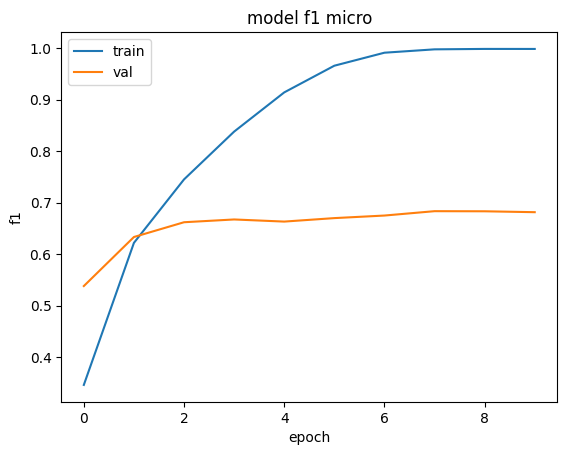

In [32]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
max(f1s_eval)

0.6832516339869281

# Пулинг

Вместе с CNN слоями часто используют пулинг слои. По сути это такие же сверточные слои, но без обучаемой части. В CNN фильтры обучаются под конкретную задачу, а в пулинге фильтры фиксированы (как правило это стандартная функция - максимум, среднее). Например, MaxPooling будет брать кусочек входной последовательности и передавать дальше максимальное значение в этом кусочке.

Параметры пулинга практически такие же как и в CNN (kernel_size, stride), но нет in_channels, out_channels, так как размерность вектора никак не меняется. Расчитать длину последовательности после пулинга можно также как и в CNN - нужно знать длину входной последовательности, kernel_size и stride.

In [43]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.KERNEL_SIZE = 5
        self.MAX_LEN = 200
        self.IN_CHANNELS = self.EMB_DIM
        self.OUT_CHANNELS = 128
        self.STRIDE = 2
        self.STRIDE_POOL = 2
        self.KERNEL_SIZE_POOL = 2
        self.HIDDEN_FC = 64
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE) 
        
        # считаем длину после снн
        self.conv_length = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1))
        
        
        # пулинг с максимумом
        self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE_POOL, 
                                     stride=self.STRIDE_POOL) 
        # также считаем длину после пулинга
        self.pool_length = int((((self.conv_length-(self.KERNEL_SIZE_POOL-1)-1)/self.STRIDE_POOL)+1))
        
        
        # функций активации много 
        # релу самая популярная
        # у нее есть вариант с "протечкой"
        # в нем отрицательные значений зануляются не полностью
        # а с каким-то маленьким коэффициентом (0.05) например
        self.relu = torch.nn.LeakyReLU()
        
        
        # считаем размерность конкатенированного вектора
        # умножаем размерность вектора после CNN на длину последовательности после пулинга
        self.fc = nn.Linear(self.OUT_CHANNELS * self.pool_length, 
                            self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        convoluted = self.relu(self.conv(embedded))
        pooled = self.max_pool(convoluted)
        hidden = torch.flatten(pooled, 1, -1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 
        outputs=self.act(dense_outputs)
        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [44]:
f1s = []
f1s_eval = []

for epoch in range(10):
    print(f"\nEpoch {epoch+1}/10")

    train_f1 = train(model, training_generator, optimizer, criterion)
    val_f1 = evaluate(model, valid_generator, criterion)

    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    f1s.append(train_f1)
    f1s_eval.append(val_f1)



Epoch 1/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.3381 | Val F1: 0.5228

Epoch 2/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6054 | Val F1: 0.6246

Epoch 3/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7431 | Val F1: 0.6405

Epoch 4/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.8416 | Val F1: 0.6757

Epoch 5/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9226 | Val F1: 0.6735

Epoch 6/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9754 | Val F1: 0.6841

Epoch 7/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9953 | Val F1: 0.6796

Epoch 8/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9982 | Val F1: 0.6841

Epoch 9/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9985 | Val F1: 0.6895

Epoch 10/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9988 | Val F1: 0.6878


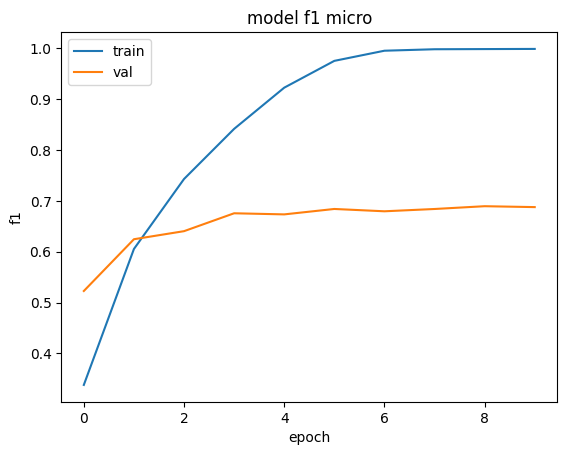

In [47]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
max(f1s_eval)

0.6895475898692811

# Регуляризация

Для того, чтобы сократить переобучение (а часто и просто чтобы улучшить качество) используют BatchNorm, DropOut и регуляризацию. 

DropOut - самый простой метод, он просто с какой-то вероятностью зануляет числа во входной матрице (есть еще dropout который зануляет рандомно, но уже сразу целиком какую-то размерность; в нашем случае он может например во всех эмбедингах занулить 2 и 5 элементы. Такой дропаут в торче называется DropOut2d). Использовать его очень легко - ```drop = nn.Dropout(0.3); drop(input)``` (также как relu в предыдущих примерах, но с 1 параметром). Для сверток Dropout однако почти не используют. 

В свертках используют BatchNorm. BatchNorm нормализует числа внутри батча так, чтобы они лежали в каком-то фиксированном интервале (от до 1). Это помогает сделать модель более устойчивой к изменениями во входных данных (например, если какое-то значение вдруг слишком сильно увеличится, то батчнорм не позволит ему слишком сильно повлиять на последующие слои), а также просто ускоряет обучение. Технически батчнорм не очень простой (там еще есть обучаемые параметры), вот несколько видео, если вам интересно разобраться -  https://www.youtube.com/watch?v=dXB-KQYkzNU , https://www.youtube.com/watch?v=nUUqwaxLnWs

Регуляризация - это ограничения на значения параметров в модели. В торче добавить L2 регуляризацию можно в оптимайзере, задав параметр weight_decay и указав веса какого слоя нужно регуляризировать. Скорее всего вам это не пригодится, но полезно знать про такую возможность.

Добавим батчнорм и регуляризацию.

In [57]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.KERNEL_SIZE = 5
        self.MAX_LEN = 200
        self.IN_CHANNELS = self.EMB_DIM
        self.OUT_CHANNELS = 128
        self.STRIDE = 2
        self.STRIDE_POOL = 2
        self.KERNEL_SIZE_POOL = 2
        self.HIDDEN_FC = 64
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE) 
        self.conv_length = int((((self.MAX_LEN-(self.KERNEL_SIZE-1)-1)/self.STRIDE)+1))
        
        # инициализируем батчнорм
        self.batch_norm = nn.BatchNorm1d(self.OUT_CHANNELS)

        
        self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE_POOL, 
                                     stride=self.STRIDE_POOL) 
        self.pool_length = int((((self.conv_length-(self.KERNEL_SIZE_POOL-1)-1)/self.STRIDE_POOL)+1))
        
        self.relu = torch.nn.LeakyReLU()
        

        self.fc = nn.Linear(self.OUT_CHANNELS * self.pool_length, 
                            self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        convoluted = self.conv(embedded)
        # я не нашел совсем достоверной информации, но пару авторитетных мнений
        # указывают на то, что батчнорм нужно ставить после свертки-пулинга-активации
        # а не где-то внутри этой тройки
        # то есть нужно держаться структуры свертка-*пулинг*-активация-батчнорм (пулинг опциональный)
        pooled = self.batch_norm(self.relu(self.max_pool(convoluted)))
        hidden = torch.flatten(pooled, 1, -1)
        hidden = self.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 
        outputs=self.act(dense_outputs)
        
        return outputs



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam([{'params':model.fc_1.parameters()},
                        {'params':model.conv.parameters()},
                        {'params':model.embedding.parameters()},
                        {'params': model.fc.parameters(), 'weight_decay':0.1}],  # указываем в этом слое L2 регуляризацию
                                                                                 # можно пробовать значения как в sklearn
                                                                                 # в параметре C в логреге
                       
                         lr=0.001) # лернирг рейт тоже можно отдельно указать выше, но мы используем 1 на все слои
criterion = nn.CrossEntropyLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [56]:
model.conv_length

98

In [58]:
f1s = []
f1s_eval = []

for epoch in range(10):
    print(f"\nEpoch {epoch+1}/10")

    train_f1 = train(model, training_generator, optimizer, criterion)
    val_f1 = evaluate(model, valid_generator, criterion)

    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    f1s.append(train_f1)
    f1s_eval.append(val_f1)



Epoch 1/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.3831 | Val F1: 0.5582

Epoch 2/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6121 | Val F1: 0.6372

Epoch 3/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6887 | Val F1: 0.6650

Epoch 4/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7403 | Val F1: 0.6902

Epoch 5/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7764 | Val F1: 0.6960

Epoch 6/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.8150 | Val F1: 0.7145

Epoch 7/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.8435 | Val F1: 0.7221

Epoch 8/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.8689 | Val F1: 0.7312

Epoch 9/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.8925 | Val F1: 0.7432

Epoch 10/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9091 | Val F1: 0.7404


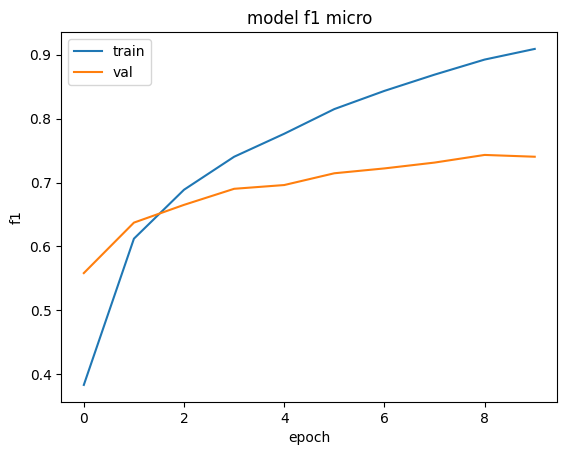

In [59]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
max(f1s_eval)

0.7431781045751634

### Несколько слоев с паддингом

Во всех сетках выше только 1 CNN слой и еще 1 доп. пулинг. Но рабочие сверточные сети это обычно десятки сверток и пулингов, которые наслаиваются друг на друга. Из когда выше видно, что собрать такую сетку будет непросто - будет очень много промежуточного когда для расчета размерностей. Чтобы этого избежать можно написать отдельный класс, который будет применять сверточный слой и сохранять длину последовательности. Для этого мы воспользуемся паддингом - добьем нулями исходную последовательность, чтобы на выходе получилась изначальная длина.

In [69]:
# созданный класс в торче можно использовать просто как слой!

class Conv_layer_with_pad(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        
        super().__init__()          
        self.KERNEL_SIZE = 7
        self.IN_CHANNELS = in_channels
        self.OUT_CHANNELS = out_channels
        self.STRIDE = 1
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE, ) 
        
        self.act = nn.LeakyReLU()
        
    def forward(self, embedded):
        """
        Раньше мы расчитывали длину, которая получится, после применения сверточного слоя  по формуле:
        OUTPUT_LENGTH = (((MAX_LEN-(KERNEL_SIZE-1)-1)/STRIDE)+1)
        
        
        Теперь мы хотим на выходе получить длину, которая будет соответствовать длине изначальной последовательности.
        Т.е. мы знаем OUTPUT_LENGTH и наша задача найти такой MAX_LEN, при котором он получается (остальные параметры фиксированы)
        Перенесем все известные значения влево и получится вот такая формула
        ((OUTPUT_LENGTH-1)*STRIDE)+1+(KERNEL_SIZE-1) = MAX_LEN
        
        Используя нужное значение MAX_LEN, нам нужно допаддить изначальную последовательность до этой длины
        Т.к. мы будет падить с двух сторон, то нужно, чтобы получившееся число делилось на 2
        
        
        
        """
        MAX_LEN = embedded.size(2)
        EXP_LEN = ((MAX_LEN-1)*self.STRIDE)+1+(self.KERNEL_SIZE-1)

        # нужно чтобы все сходилось, иначе выдавать ошибку
        assert not (EXP_LEN-MAX_LEN)%2, f"Не ровный паддинг! {EXP_LEN}"
        
        # допустим чтобы получить изначальную длину в 200
        # нужно добавить нулей до 210
        # тогда мы добавляем 5 нулей слева и 5 справа
        # ассерт выше выкинул бы ошибку если бы у нас получалось например 209, 
        # то есть мы не смогли бы ровно западить с 2 сторон
        padded = F.pad(embedded, (int((EXP_LEN-MAX_LEN)/2), 
                                                   int((EXP_LEN-MAX_LEN)/2)))
        
        convoluted = self.conv(padded)
        
        return self.act(convoluted)


class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.KERNEL_SIZE = 7
        self.MAX_LEN = 200
        self.OUT_CHANNELS = 32
        self.OUT_CHANNELS_1 = 16
        self.STRIDE = 1
        self.HIDDEN_FC = 64
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        # теперь слои удобно стакать
        # нужно только указывать OUT_CHANNELS как IN_CHANNELS в следующем слое
        self.conv = Conv_layer_with_pad(self.EMB_DIM, self.OUT_CHANNELS)
        self.conv1 = Conv_layer_with_pad(self.OUT_CHANNELS, self.OUT_CHANNELS_1)
        self.relu = nn.ReLU()
        # если бы мы поставили еще 1 слой, то его IN_CHANNELS была бы 16 и тд

        # длина сохраняется поэтому просто умножаем макс лен на OUT_CHANNELS последнего слоя
        self.flattened_size = int(self.MAX_LEN*self.OUT_CHANNELS_1)
        
        self.fc = nn.Linear(self.flattened_size, 
                            self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        # print(embedded.size())
        convoluted = self.relu(self.conv1(self.conv(embedded.permute(0, 2, 1))))
        # print(convoluted.size())
        hidden = torch.flatten(convoluted, 1, -1)
        # print(hidden.size())
        hidden = torch.relu(self.fc(hidden))
        dense_outputs=self.fc_1(hidden) 
        outputs=self.act(dense_outputs)

        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [70]:
f1s = []
f1s_eval = []

for epoch in range(10):
    print(f"\nEpoch {epoch+1}/10")

    train_f1 = train(model, training_generator, optimizer, criterion)
    val_f1 = evaluate(model, valid_generator, criterion)

    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    f1s.append(train_f1)
    f1s_eval.append(val_f1)



Epoch 1/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.2965 | Val F1: 0.4588

Epoch 2/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.5545 | Val F1: 0.6235

Epoch 3/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6698 | Val F1: 0.6593

Epoch 4/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7313 | Val F1: 0.6774

Epoch 5/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7821 | Val F1: 0.6841

Epoch 6/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.8257 | Val F1: 0.7052

Epoch 7/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.8694 | Val F1: 0.7091

Epoch 8/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9092 | Val F1: 0.7088

Epoch 9/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9423 | Val F1: 0.6987

Epoch 10/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.9675 | Val F1: 0.6961


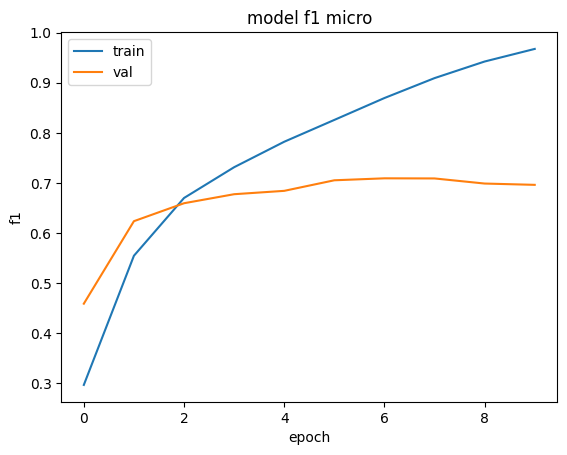

In [71]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
max(f1s_eval)

0.7090941584967321

Можно написать тоже самое чуть более идеоматично (так как приняно писать)

In [73]:
import torch
import torch.nn as nn


class ConvBNAct1d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 7,
        stride: int = 1,
        activation: nn.Module | None = None,
    ):
        super().__init__()
        # if kernel_size % 2 == 0:
        #     raise ValueError("Use an odd kernel_size to preserve length with symmetric padding.")
        # if stride != 1:
        #     raise ValueError("This block assumes stride=1 to preserve length with symmetric padding.")

        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=kernel_size // 2,
            bias=False,  
        )
        self.bn = nn.BatchNorm1d(out_channels)
        self.act = activation if activation is not None else nn.LeakyReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.bn(self.conv(x)))


class Clf(nn.Module):
    def __init__(
        self,
        output_dim: int,
        vocab_size: int,
        emb_dim: int = 100,
        max_len: int = 200,
        conv_channels: tuple[int, ...] = (32, 16),
        kernel_size: int = 7,
        hidden_fc: int = 64,
        dropout_p: float = 0.2,
    ):
        super().__init__()
        self.VOCAB_SIZE = vocab_size
        self.EMB_DIM = emb_dim
        self.MAX_LEN = max_len
        self.HIDDEN_FC = hidden_fc

        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.emb_dropout = nn.Dropout(dropout_p)

        channels = (self.EMB_DIM, *conv_channels)
        self.convs = nn.ModuleList([
            ConvBNAct1d(channels[i], channels[i + 1], kernel_size=kernel_size, stride=1)
            for i in range(len(channels) - 1)
        ])

        final_channels = channels[-1]
        self.flattened_size = self.MAX_LEN * final_channels

        self.fc_dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(self.flattened_size, self.HIDDEN_FC)
        self.fc_1 = nn.Linear(self.HIDDEN_FC, output_dim)
        self.act = nn.LogSoftmax(dim=1)

    def forward(self, text: torch.Tensor) -> torch.Tensor:
        x = self.embedding(text)          
        x = self.emb_dropout(x)
        x = x.permute(0, 2, 1)            

        for conv in self.convs:
            x = conv(x)                   

        x = torch.flatten(x, 1)          
        x = self.fc_dropout(x)
        x = torch.relu(self.fc(x))
        x = self.fc_dropout(x)

        x = self.fc_1(x)
        return self.act(x)


In [75]:
model = Clf(
    output_dim=len(label2id),
    vocab_size=len(word2id),
    emb_dim=100,
    max_len=200,
    conv_channels=(32, 16),
    kernel_size=7,
    hidden_fc=64,
    dropout_p=0.2,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [76]:
f1s = []
f1s_eval = []

for epoch in range(10):
    print(f"\nEpoch {epoch+1}/10")

    train_f1 = train(model, training_generator, optimizer, criterion)
    val_f1 = evaluate(model, valid_generator, criterion)

    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    f1s.append(train_f1)
    f1s_eval.append(val_f1)


Epoch 1/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.2756 | Val F1: 0.4149

Epoch 2/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.4694 | Val F1: 0.5482

Epoch 3/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.5637 | Val F1: 0.6140

Epoch 4/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6208 | Val F1: 0.6609

Epoch 5/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6642 | Val F1: 0.6867

Epoch 6/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.6981 | Val F1: 0.6936

Epoch 7/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7236 | Val F1: 0.7150

Epoch 8/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7406 | Val F1: 0.7195

Epoch 9/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7587 | Val F1: 0.7440

Epoch 10/10


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Train F1: 0.7764 | Val F1: 0.7377


In [77]:
max(f1s_eval)

0.7440359477124183

## Работа с картинками

In [83]:
import os

In [79]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  30.1M      0  0:00:26  0:00:26 --:--:-- 32.1M


In [80]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   ports.log
 PetImages		   lenta_40k.csv.zip	       'readme[1].txt'
 cnn_torch.ipynb	   onstart.sh


In [81]:
!ls PetImages

Cat  Dog


In [84]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [85]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import random

In [86]:
data_transform = transforms.Compose([
                                     transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [87]:
data = datasets.ImageFolder(
    root="PetImages",
    transform=data_transform,
    
)

In [88]:
len(data)

23410

In [89]:
training_data, validation_data = torch.utils.data.random_split(data, lengths=[len(data)-100, 100])

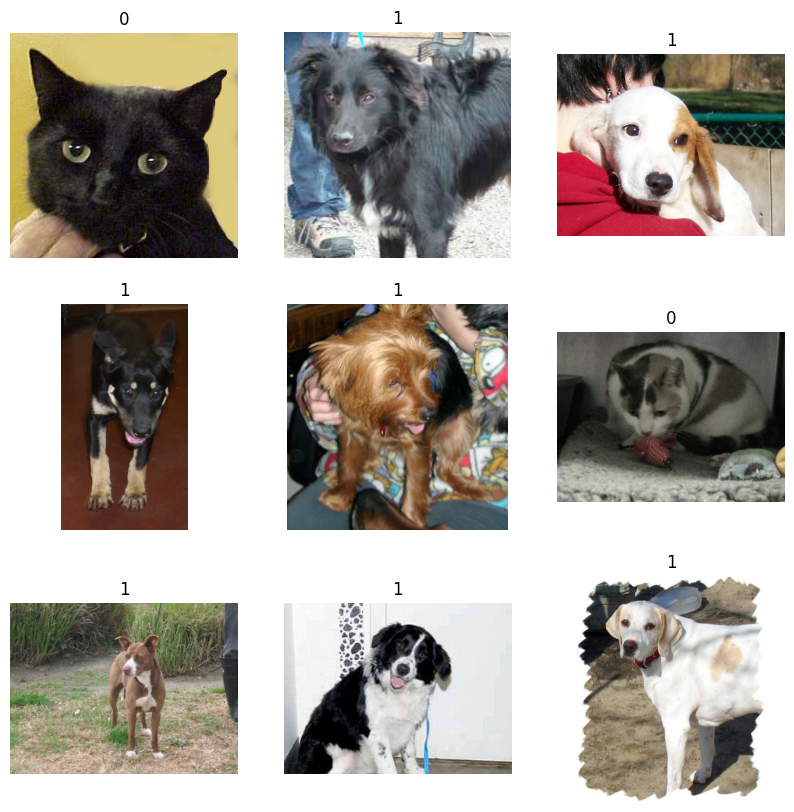

In [90]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(random.choices(validation_data.dataset.samples, k=9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(np.array(Image.open(image)))
    plt.title(int(label))
    plt.axis("off")

In [91]:
batch_size = 32

trainLoader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, 
                                           drop_last=True, shuffle=True)
valLoader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
  

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, kernel_size: int = 3, padding: int = 1, bias: bool = False):
        super().__init__()
        # depthwise: groups=in_ch keeps channels separate
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, padding=padding, groups=in_ch, bias=bias)
        # pointwise: 1x1 mixes channels
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class DogCatModel(nn.Module):
    def __init__(self, dropout_p: float = 0.25):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1, bias=False)  # "same" for k=3 => padding=1
        self.bn1 = nn.BatchNorm2d(128)

        self.sep = SeparableConv2d(128, 1024, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(1024)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # global average pool
        self.drop = nn.Dropout(dropout_p)
        self.fc = nn.Linear(1024, 1)  # Dense(1)

    def forward(self, x):
        # x: (B, 3, 224, 224) channels_first
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)

        x = self.sep(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)

        x = self.gap(x)              # (B, 1024, 1, 1)
        x = torch.flatten(x, 1)      # (B, 1024)
        x = self.drop(x)
        x = self.fc(x)               # (B, 1) logits
        return x


In [93]:
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import numpy as np
import torch

def train_one_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = []
    epoch_f1 = []

    pbar = tqdm(iterator, desc="Training", leave=False)

    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        # y expected as 0/1; BCE wants float
        y = y.to(device, non_blocking=True).float().view(-1)

        optimizer.zero_grad(set_to_none=True)

        logits = model(x).view(-1)                 # (B,)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long().cpu().numpy()
            y_true = y.long().cpu().numpy()

            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

        pbar.set_postfix(loss=float(np.mean(epoch_loss)), f1=float(np.mean(epoch_f1)))

    return float(np.mean(epoch_f1)), float(np.mean(epoch_loss))


@torch.no_grad()
def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = []
    epoch_f1 = []

    pbar = tqdm(iterator, desc="Valid", leave=False)

    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).float().view(-1)

        logits = model(x).view(-1)
        loss = criterion(logits, y)

        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long().cpu().numpy()
        y_true = y.long().cpu().numpy()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        pbar.set_postfix(loss=float(np.mean(epoch_loss)), f1=float(np.mean(epoch_f1)))

    return float(np.mean(epoch_f1)), float(np.mean(epoch_loss))


In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DogCatModel(dropout_p=0.25).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 6):
    train_f1, train_loss = train_one_epoch(model, trainLoader, optimizer, criterion, device)
    val_f1, val_loss = evaluate(model, valLoader, criterion, device)

    print(f"Epoch {epoch:02d} | train loss {train_loss:.4f} f1 {train_f1:.4f} | val loss {val_loss:.4f} f1 {val_f1:.4f}")


Training:   0%|          | 0/728 [00:00<?, ?it/s]

Valid:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 01 | train loss 0.6364 f1 0.6334 | val loss 0.6692 f1 0.6172


Training:   0%|          | 0/728 [00:00<?, ?it/s]

KeyboardInterrupt: 

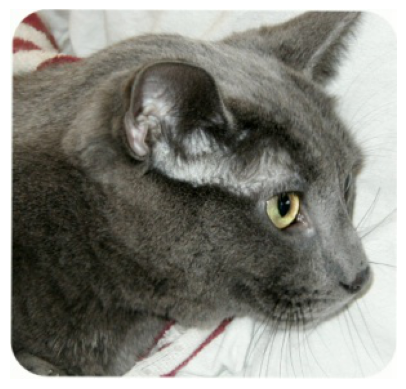

This image is 55.62% cat and 44.38% dog.


In [95]:
img = Image.open("PetImages/Cat/6779.jpg").convert("RGB")

plt.imshow(img)
plt.axis("off")
plt.show()

model.eval()
with torch.no_grad():
    x = data_transform(img).unsqueeze(0).to(device)   # (1,3,224,224)
    logits = model(x).view(-1)[0]                     # scalar logit
    score = torch.sigmoid(logits).item()              # P(dog)

print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")